In [1]:
import itertools as it
import json
import re
import warnings

import dexplot as dxp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.plotly as py
import seaborn as sns
from dfpvizpy.dfpvizpy import dfpSave
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

# Make plotly work with Jupyter notebook
init_notebook_mode(connected=True)

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
sns.set(style="ticks", context='talk')
sns.set_palette('colorblind')

In [4]:
# these are columns which are the string 'other' responses
others = ['state', 'race_t', 'senvote18_t', 'senvote18_undecided_t', 'specsenvote18_t', 'specsenvote18_undecided_t',
          'housevote18_t', 'housevote18_undecided_t', 'govvote18_t', 'govvote18_undecided_t', 'NONVOTE_WHY_t',
          'pp18_polactions_txt', 'pid3_t', 'presvote16post_t', 'e14_presvote12_t', 'religpew_t']

agree_order = ['Strongly agree', 'Somewhat agree',
            'Neither agree nor disagree', 'Somewhat disagree',
            'Strongly disagree', 'Don\'t know']

age_order = ['18-29', '30-39', '40-49', '50-64', '65+']

net_dict = {'Strongly agree': 'Positive', 'Somewhat agree': 'Positive',
            'Neither agree nor disagree': 'Neutral', 'Somewhat disagree': 'Negative',
            'Strongly disagree': 'Negative'}

state_dict = {'Alaska': 'AK', 'Alabama': 'AL', 'Arkansas': 'AR', 'Arizona': 'AZ', 
              'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'District of Columbia': 
              'DC', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Iowa': 
              'IA', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Kansas': 'KS', 'Kentucky': 
              'KY', 'Louisiana': 'LA', 'Massachusetts': 'MA', 'Maryland': 'MD', 'Maine': 'ME', 
              'Michigan': 'MI', 'Minnesota': 'MN', 'Missouri': 'MO', 'Mississippi': 'MS', 'Montana': 
              'MT', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Nebraska': 'NE', 'New Hampshire': 
              'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'Nevada': 'NV', 'New York': 'NY', 'Ohio': 
              'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 
              'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 
              'UT', 'Virginia': 'VA', 'Vermont': 'VT', 'Washington': 'WA', 'Wisconsin': 'WI', 
              'West Virginia': 'WV', 'Wyoming': 'WY'}

In [24]:
# this is the .json file with all of the questions and coding of the variables
with open('dfp_survey_questions.json', 'r') as fp:
    polling_info = json.load(fp)

In [25]:
# reading in the data to a dataframe
df = pd.read_csv('DFP_WTHH_release.csv', index_col=0)

# there are two values that need to be moved into the "employ" column
df.loc[2939]['employ'] = 6
df.loc[3110]['employ'] = 9
df.drop(columns='job', inplace=True)
df.drop(columns='weight_DFP', inplace=True)
df.fillna('?', inplace=True)

In [26]:
# # saving counts to a text file
# with open('polling_counts.txt', 'w') as f:
#     for column in df.columns:
#         if column in df.columns and column in polling_info.keys() and column not in others:
#             f.write(column + ' | ' + polling_info[column]["question"] + '\n\n')
#             f.write("*-" * 40 + '\n\n')
#             f.write(df[column].replace('?', 999).astype(int).astype(str).replace('999', '?').replace(polling_info[column]).value_counts().to_string())
#             f.write('\n\n\n')

In [27]:
data_cols = []
unknown_cols = []
for column in df.columns:
    if column in df.columns and column in polling_info.keys() and column not in others:
        df[column.title()] = df[column].replace('?', 999).astype(int).astype(str).replace('999', '?').replace(polling_info[column])
        data_cols.append((column.title(), column))
    elif (column not in df.columns or column not in polling_info.keys()) and column not in others:
        unknown_cols.append((column.title(), column))
        
df['state'] = df['state'].replace('District of Columbia', 999).astype(int).astype(str).replace('999', 'District of Columbia').replace(polling_info['state'])
data_cols.append('state')
                                                                                                                                  

In [28]:
unknown_cols

[('Has_Voted', 'has_voted'),
 ('Senvote18_Full', 'senvote18_full'),
 ('Specsenvote18_Full', 'specsenvote18_full'),
 ('Govvote18_Full', 'govvote18_full'),
 ('Which_Module', 'which_module'),
 ('House2_Imputed', 'house2_imputed'),
 ('House3', 'house3'),
 ('Gov2_Imputed', 'gov2_imputed'),
 ('Gov3', 'gov3'),
 ('Sen2_Imputed', 'sen2_imputed'),
 ('Sen3', 'sen3'),
 ('Housevote18_Full', 'housevote18_full'),
 ('Which_Sample', 'which_sample')]

In [23]:
'USR' in df

True

In [10]:
# for col, dict_col in data_cols:
#     s = sns.catplot(x='Age5', kind='count', hue=col, col='Gender', data=df, col_wrap=2, height=6, 
#                     aspect=2, legend=False, order=list(polling_info['age5'].values())[:-1])
#     # s.ax.set_ylabel('Number of Respondents')
#     # s.ax.set_xlabel('Age')
#     # s.ax.set_title(polling_info['FLAG']['question'])
#     s.axes[1].legend(frameon=False)
#     s.axes[0].set_title('Female')
#     s.axes[1].set_title('Male')
#     # s.fig.tight_layout()
#     s.fig.suptitle(polling_info[dict_col]['question'].title())
#     s.fig.subplots_adjust(top=0.8)
#     dfpSave(f'age_and_{col}.png', s.axes)
# #     plt.show()

In [12]:
def freq_table(x, hue=None, col=None):
    '''
    
    '''
    tables = []
    x_ind = x[x == '?'].index
    
    x.drop(x_ind, inplace=True)
    if hue is not None:
        hue.drop(x_ind, inplace=True)
    if col is not None:
        col.drop(x_ind, inplace=True)
    
    df = pd.get_dummies(x)
    df['Hue'] = hue
    df['Col'] = col
    
    drp_index = df[(df.Hue == '?') | (df.Col == '?')].index
    df.drop(drp_index, inplace=True)
    
    totals = df[x.unique()].sum(axis=0)
    totals['Total'] = totals.sum()
    
    for col in df.Col.unique():
        df_col = df[df.Col == col]
        grouped = df_col.groupby(by=hue).sum()
        grouped['Total'] = grouped.sum(axis=1)
        num = pd.DataFrame([grouped.sum(axis=0).values], index=['Total'], 
                           columns=grouped.sum(axis=0).index)

        x_vals = grouped.columns
        scaled = grouped.copy()

        for x_val in x_vals:
            scaled[x_val] = scaled[x_val] / totals.loc[x_val] * 100
        
        scaled.index.name = f'{col}'
        tables.append((np.round(scaled, decimals=2), len(df_col)))
    
    return tables

In [31]:
def freq_df(x, hue=None, col=None):
    col_name = col.name
    hue_name = hue.name
    x_name = x.name

    tbls = freq_table(x, hue=hue, col=col)
    df_list = []
    for dft, N in tbls:
        dft.drop('Total', axis=1, inplace=True)
        te = pd.DataFrame([(x, hue, vals) for (hue, x),
                           vals in zip(it.product(dft.index,
                                                  dft.columns),
                                       dft.values.flatten())],
                          columns=[x_name, hue_name, 'Percentage'])
        te[col_name] = dft.index.name
        te['Number'] = N
        df_list.append(te)

    df = pd.concat(df_list, ignore_index=True)
    
    return df, tbls


In [32]:
freq_dfs, freq_tables = freq_df(df.Age5, hue=df.Gender, col=df.Race_Ident)

In [33]:
freq_dfs

,Age5,Gender,Percentage,Race_Ident,Number
0,18-29,Female,19.76,Very important,728
1,30-39,Female,18.09,Very important,728
2,40-49,Female,18.87,Very important,728
3,50-64,Female,14.13,Very important,728
4,65+,Female,9.27,Very important,728
5,18-29,Male,3.59,Very important,728
6,30-39,Male,6.14,Very important,728
7,40-49,Male,9.30,Very important,728
8,50-64,Male,8.81,Very important,728
9,65+,Male,11.44,Very important,728


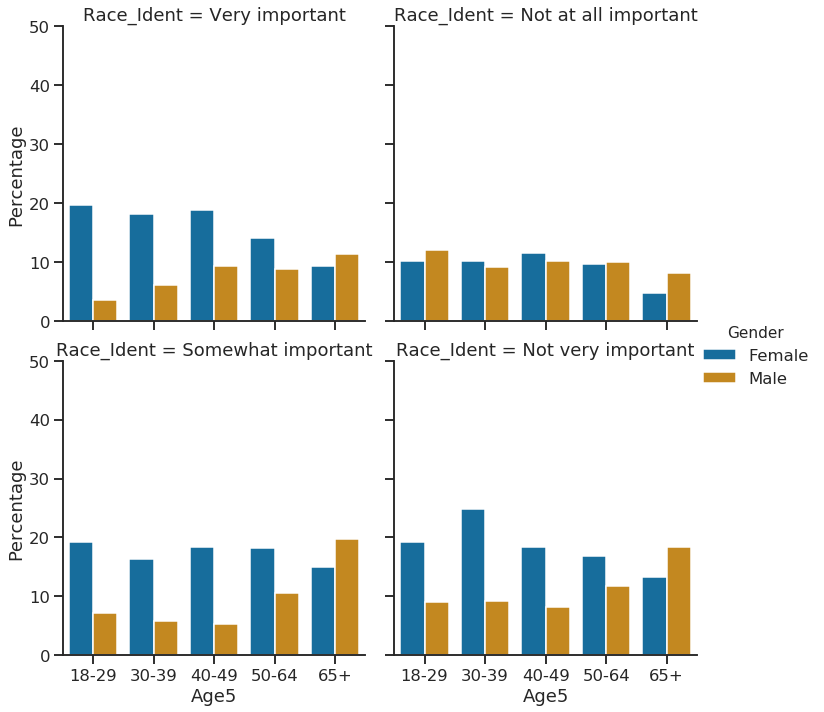

In [40]:
s = sns.catplot(x='Age5', y='Percentage', hue='Gender', col='Race_Ident', 
                data=freq_dfs, kind='bar', col_wrap=2)
for ax in s.axes:
    ax.set_xticklabels(age_order)
    ax.set_ylim([0, 50])
# s.figure.set_figheight(10)
# s.figure.set_figwidth(15)
# s.axes.tick_params(axis='x', rotation=45)
# s.axes.set_xlabel('')

In [47]:
li = []
for age in freq_dfs.Age5.unique():
    sm = freq_dfs[freq_dfs.Age5 == age]
#     li.append([age, 
    li.append([age, sm[sm.Remarks == 'Positive']['Percentage'].values[0] - sm[sm.Remarks == 'Negative']['Percentage'].values[0]])

AttributeError: 'DataFrame' object has no attribute 'Remarks'

In [48]:
dfc = pd.DataFrame(li, columns=['Age', 'Net Positivity'])
dfc

,Age,Net Positivity


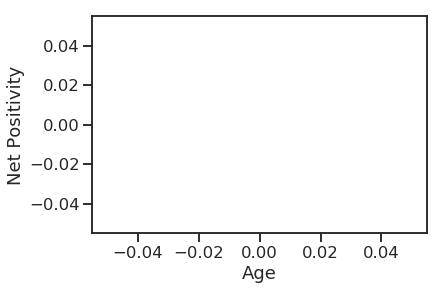

In [49]:
sns.lineplot(x='Age', y='Net Positivity', data=dfc)

In [ ]:
state_dict = {f'{value}': f'{key}' for key, value in state_dict.items()}

In [ ]:
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

df['text'] = df['state']
df['z'] = df.Ft_Blacks.replace('?', '0').astype(float) - 50
df['location'] = df.state.replace(state_dict)

data = [dict(
        type='choropleth',
        colorscale = 'YIOrRd',
        autocolorscale = True,
        locations = df.location,
        z = df.z,
        locationmode = 'USA-states',
        text = df.text,
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = 'Trust')
        )]

layout = dict(
        title = polling_info['FT_Blacks']['question'],
        geo = dict(
            scope='usa',
            projection=dict(type='albers usa'),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map.html')

In [ ]:
print(polling_info['FT_Whites']['question'])

dft = df[['FT_Whites', 'race']]
dft.race = dft['race'].replace('?', 999).astype(int).astype(str).replace('999', '?').replace(polling_info['race'])
dft = dft[dft.FT_Whites != '?']
dft.FT_Whites = dft["FT_Whites"].astype(float)
dfg = dft.groupby(['race']).median()
sort_order = dfg.sort_values(by='FT_Whites', ascending=False).index.tolist()

x_dat = df["race"].replace('?', 999).astype(int).astype(str).replace('999', '?').replace(polling_info['race'])
f, ax = plt.subplots(figsize=(13, 8))
idx = df[df.FT_Blacks != '?']
df_new = idx[idx.FT_Whites != '?']
ax = sns.boxplot(y=x_dat, x=df_new["FT_Whites"].astype(float), order=sort_order)
ax.set_ylabel('')
ax.set_title('Feelings Toward White People')
ax.set_xlabel('')
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_xticklabels(['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
dfpSave('feelings_towards_white_people_by_race.png', [ax])
plt.show()

In [ ]:
table = pd.pivot_table(df, index=['Age', 'Party'], columns=['Gender'], aggfunc=np.sum)
display(table)

In [ ]:
for x in table:
    print(x)

In [ ]:
df.Age.head(5)

In [ ]:
for name in np.sort(df.columns):
    print(df[name].head(5))

In [ ]:
list(polling_info['FLAG'].values())

In [ ]:
polling_info['FLAG']['question']

In [ ]:
df['Gender'].value_counts()

In [52]:
df.state.value_counts().sort_index().sum()

3215